<a href="https://colab.research.google.com/github/marianadc01/pml-assignments/blob/main/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mariana Dias Coelho (25605)

Curricular Unit - Practical Machine Learning

MSc in Green Data Science

**Assignment 7**

3 minute video + upload to Moodle

What to do:
  - Read carefully the notebook corn leaf disease which classifies with high precision images of corn leaves into 4 classes: Blight, Common_Rust, Gray_Leaf_Spot and Healthy;
  - Implement that code or some similar code either on Colab or on your own machine and compare the your results with the results reported in the notebook for the same corn diseases data set;

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'corn-or-maize-leaf-disease-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F967819%2F1637108%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240501%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240501T145645Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72ac3308a75c2cb00374603eea949e587974d4852fe59fbfe19b3f8efc0bc42465dc2aa193382a9fb4da8ac06d10f338a1ca1c004995c41fda03fc060a7b43c250920fa2b5fe8169af838ef629a8edf7ade44d249fc7f658cd17dffdffc22658e02fef93842b965c42091dfa4432cae981e5216a7c92f9f338a863be4314830c90d2245d5fd46ed2d15d64849a3829b04a5fe0836d467ffb39932f381b8221404b226c4906a799fd682a2c426db122d9880cc33213bbb7be85de1993dee09d6ebfa75fbf3f85080cc57f4fd6e28ff18fbc3981420b6f3846df40caebebe7bc1f6970d299539c3921d84b369614b8a802ae488dde02bff725ff27b460cb970acf'

# Update file paths
KAGGLE_INPUT_PATH = '/content/drive/MyDrive/kaggle/input'
KAGGLE_WORKING_PATH = '/content/drive/MyDrive/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


Mounted at /content/drive
[==================================================] 168591426 bytes downloaded

## <center>Corn Leaf Disease Detection</center>

## Importing Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

## Choosing the Device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Splitting the Data Into Train, Validation and Test Sets

In [ ]:
splitfolders.ratio("/content/drive/MyDrive/kaggle/input/corn-or-maize-leaf-disease-dataset/data",
            output="/content/drive/MyDrive/kaggle/working/splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Copying files: 4188 files [01:12, 57.93 files/s]


## Data Transformation

In [ ]:
#----------------------
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# -------- Transformation for the Whole Dataset for Visualization Purposes --------
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

## Loading the Data

In [ ]:
train = datasets.ImageFolder(root="/content/drive/MyDrive/kaggle/working/splitted_data/train",
                              transform=train_transform)

val = datasets.ImageFolder(root="/content/drive/MyDrive/kaggle/working/splitted_data/val",
                              transform=val_transform)

test = datasets.ImageFolder(root="/content/drive/MyDrive/kaggle/working/splitted_data/test",
                              transform=test_transform)

# -------- Getting the Whole Dataset for Visualization Purposes --------
data = datasets.ImageFolder(root="/content/drive/MyDrive/kaggle/input/corn-or-maize-leaf-disease-dataset",
                              transform=data_transform)

In [ ]:
print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

Dataset Labels:
 {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3} 

Images per Class in TRAIN:
1    914
3    813
0    802
2    401
Name: count, dtype: int64 

Images per Class in VALIDATION:
1    261
3    232
0    229
2    114
Name: count, dtype: int64 

Images per Class in TEST:
1    131
3    117
0    115
2     59
Name: count, dtype: int64 



#### Plotting a few Images

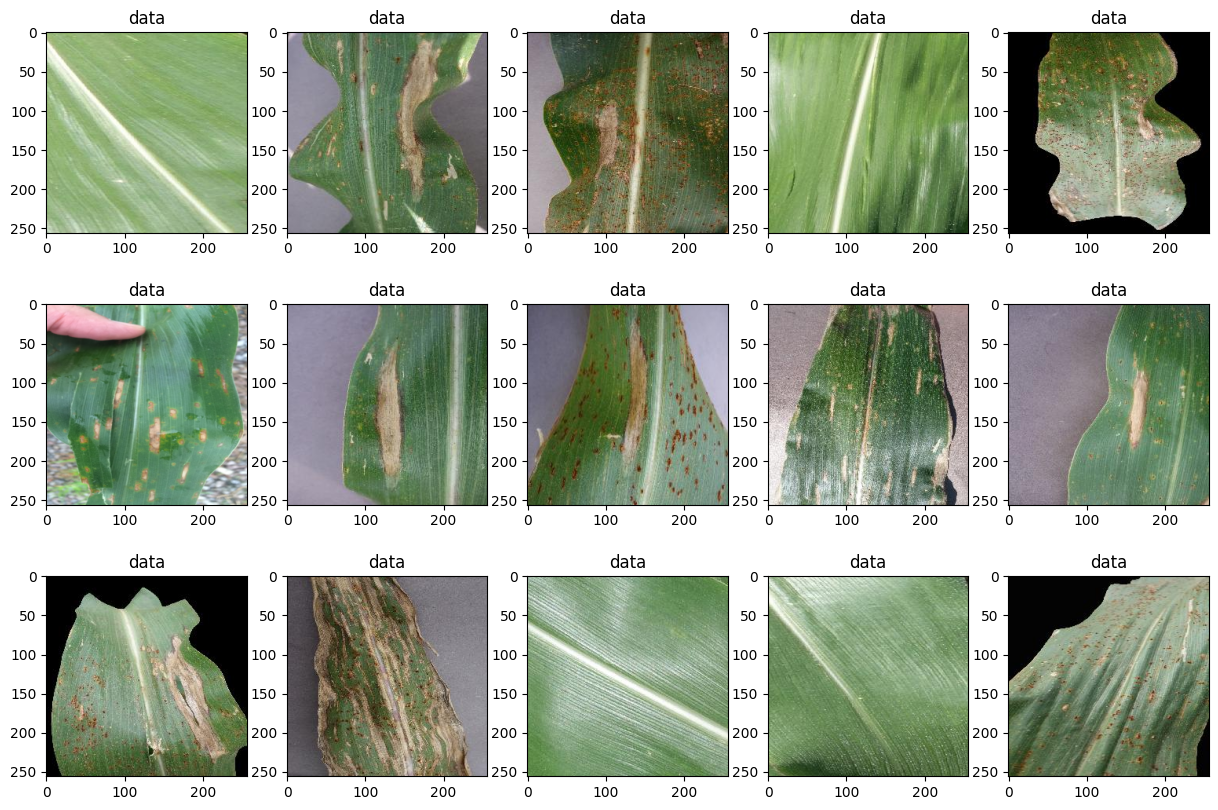

In [ ]:
labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data))
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

### Plotting the Augmented Images

Sample Label Index: 3
Sample Label Index: 0
Sample Label Index: 0
Sample Label Index: 1
Sample Label Index: 1
Sample Label Index: 1
Sample Label Index: 0
Sample Label Index: 0
Sample Label Index: 3
Sample Label Index: 3
Sample Label Index: 0
Sample Label Index: 3
Sample Label Index: 2


Sample Label Index: 0
Sample Label Index: 0


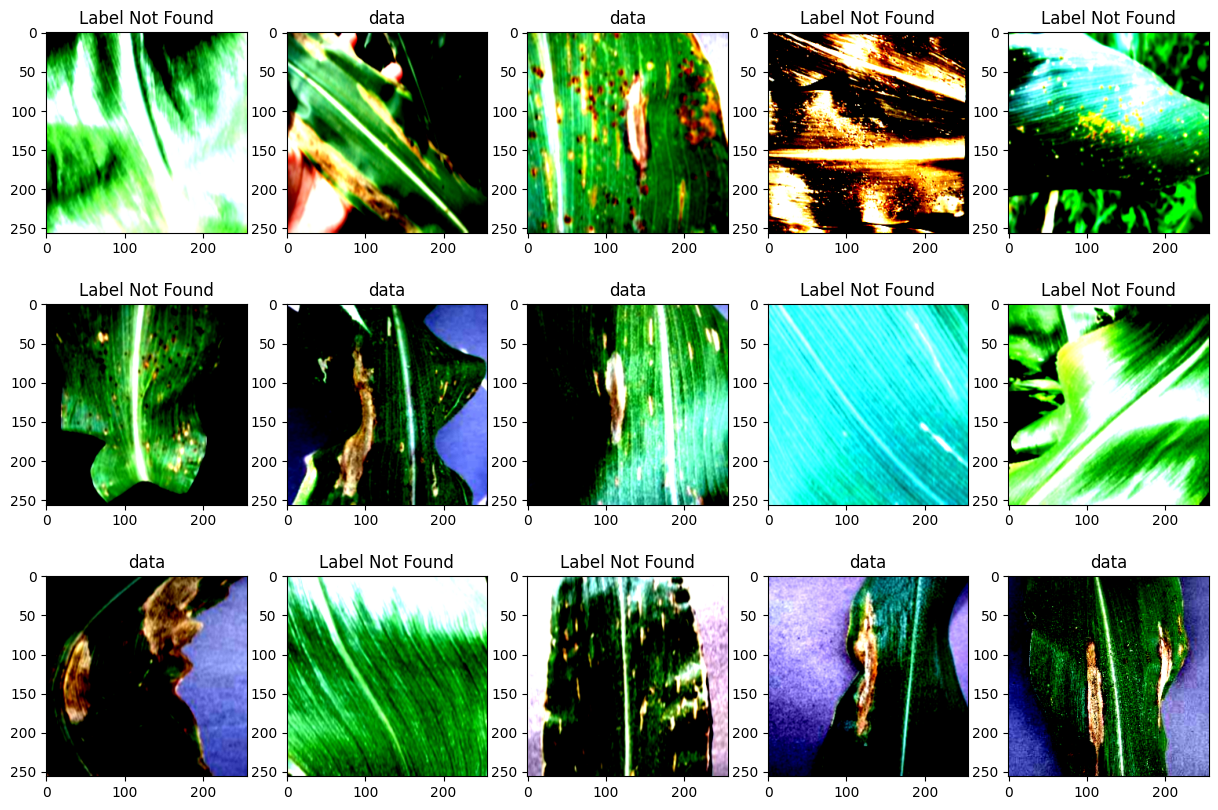

In [ ]:
random.seed(42)

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample_idx = random.randint(0, len(train) - 1)
    sample_image, sample_label = train[sample_idx]
    print("Sample Label Index:", sample_label)
    ax[i].imshow(sample_image.permute(1, 2, 0))

    if sample_label in labels_for_viz:
        ax[i].title.set_text(labels_for_viz[sample_label])
    else:
        ax[i].title.set_text("Label Not Found")


In [ ]:
train_dataloader = DataLoader(dataset=train,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

val_dataloader = DataLoader(dataset=val,
                             batch_size=32,
                             num_workers=2,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test,
                             batch_size=32,
                             num_workers=2,
                             shuffle=False)

In [ ]:
img, label = next(iter(train_dataloader))
print("Batch and Image Shape:", img.shape, "--> [batch_size, color_channels, height, width]")
print("\nLabels:", label)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch and Image Shape: torch.Size([32, 3, 256, 256]) --> [batch_size, color_channels, height, width]

Labels: tensor([1, 0, 0, 0, 1, 3, 1, 3, 3, 3, 1, 2, 2, 0, 0, 3, 0, 1, 0, 3, 1, 1, 3, 0,
        3, 0, 1, 3, 0, 1, 0, 1])


## Building the Deep Learning Model

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=131072, out_features=32), # in_features are selected based on the output that Flatten layer yields
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=4)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x

## Transfer Learning - ResNet18

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Defining the Loss Function and Choosing an Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=10e-3)

## Defining Train and Test Functions

In [ ]:
def train_and_validate_model(num_epochs):
    val_best_accuracy = 0.0
    train_loss_history = []
    val_loss_history = []
    train_accuracy_history = []
    val_accuracy_history = []

    print("Training begins...")
    for epoch in range(1, num_epochs+1):
        running_train_loss = 0.0
        running_train_accuracy = 0.0
        train_total = 0
        running_val_accuracy = 0.0
        running_val_loss = 0.0
        val_total = 0


        # TRAINING LOOP
        for data in train_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, outputs)
            _, train_predicted = torch.max(predictions, 1)
            running_train_accuracy += (train_predicted == outputs).sum().item()
            train_total += outputs.size(0)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        train_loss_value = running_train_loss/len(train_dataloader)
        train_loss_history.append(train_loss_value)
        train_accuracy = (100*running_train_accuracy)/train_total
        train_accuracy_history.append(train_accuracy)

        # VALIDATION LOOP
        with torch.no_grad():
            model.eval()
            for data in val_dataloader:
                inputs, outputs = data
                inputs, outputs = inputs.to(device), outputs.to(device)
                predictions = model(inputs)
                val_loss = loss_fn(predictions, outputs)

                _, val_predicted = torch.max(predictions, 1)
                running_val_loss += val_loss.item()
                val_total += outputs.size(0)
                running_val_accuracy += (val_predicted == outputs).sum().item()

        val_loss_value = running_val_loss/len(val_dataloader)
        val_loss_history.append(val_loss_value)
        val_accuracy = (100*running_val_accuracy)/val_total
        val_accuracy_history.append(val_accuracy)

        if val_accuracy > val_best_accuracy:
            torch.save(model.state_dict(), "model.pth")
            val_best_accuracy = val_accuracy

        print("Completed Epoch: ", epoch, "- Training Accuracy: %d" %train_accuracy, "- Validation Accuracy: %d" %val_accuracy, "- Training Loss: %.4f" %train_loss_value, "- Validation Loss: %.4f" %val_loss_value)
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

In [ ]:
def test_model():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(in_features=512, out_features=4)
    model = model.to(device)
    path = "model.pth"
    model.load_state_dict(torch.load(path))
    model.eval()

    running_accuracy = 0
    total = 0
    all_predictions = []

    with torch.no_grad():
        for data in test_dataloader:
            inputs, outputs = data
            inputs, outputs = inputs.to(device), outputs.to(device)
            outputs = outputs.to(torch.float32)
            predictions = model(inputs)
            _, predicted = torch.max(predictions, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
            accuracy = 100*running_accuracy/total

            all_predictions.append(list(predicted.to("cpu").numpy()))
        print("Test Accuracy: ", accuracy)
    return np.hstack(all_predictions) # returns a flattened array of batches of predictions

In [ ]:
EPOCHS = 5
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")
all_preds = test_model()

Training begins...
Completed Epoch:  1 - Training Accuracy: 93 - Validation Accuracy: 93 - Training Loss: 0.1776 - Validation Loss: 0.1537
Completed Epoch:  2 - Training Accuracy: 95 - Validation Accuracy: 94 - Training Loss: 0.1296 - Validation Loss: 0.1488
Completed Epoch:  3 - Training Accuracy: 95 - Validation Accuracy: 95 - Training Loss: 0.1330 - Validation Loss: 0.1087
Completed Epoch:  4 - Training Accuracy: 96 - Validation Accuracy: 95 - Training Loss: 0.1110 - Validation Loss: 0.1289
Completed Epoch:  5 - Training Accuracy: 96 - Validation Accuracy: 94 - Training Loss: 0.1041 - Validation Loss: 0.1486
Training finished...

Test Accuracy:  95.260663507109


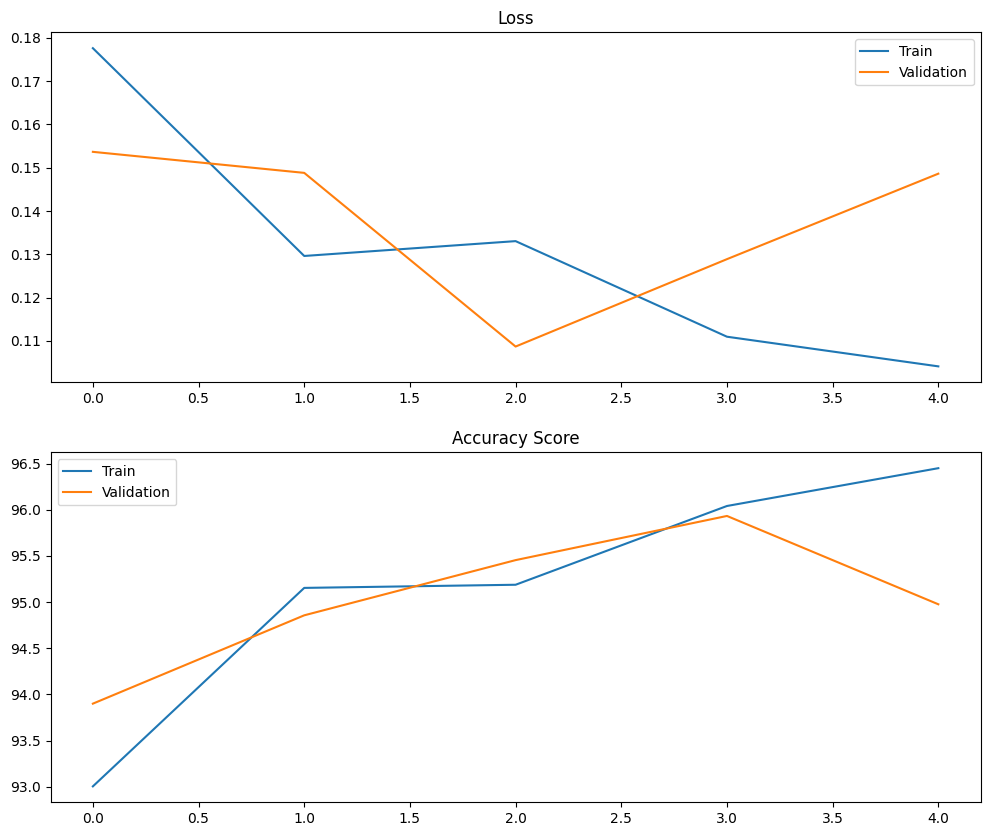

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

In [ ]:
print(classification_report(test.targets, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       115
           1       0.97      0.98      0.98       131
           2       0.81      0.93      0.87        59
           3       1.00      1.00      1.00       117

    accuracy                           0.95       422
   macro avg       0.94      0.95      0.94       422
weighted avg       0.96      0.95      0.95       422



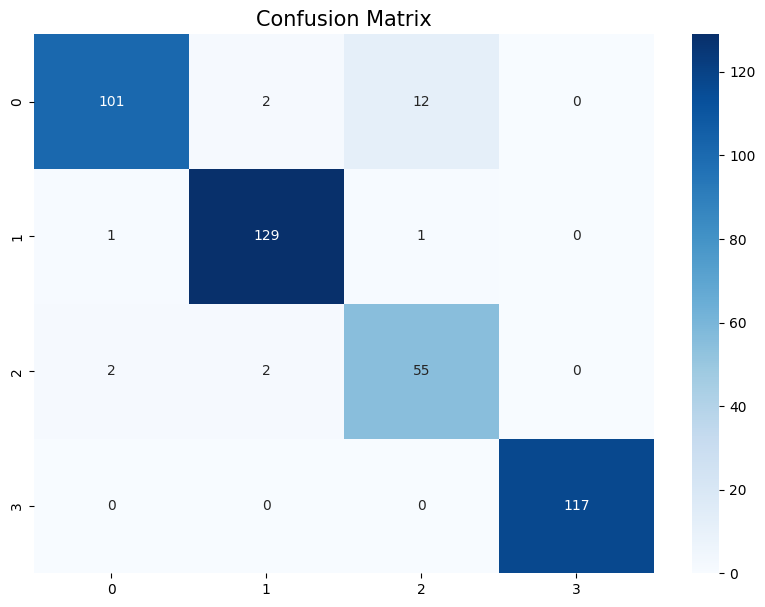

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

## Manual Testing

KeyError: 3

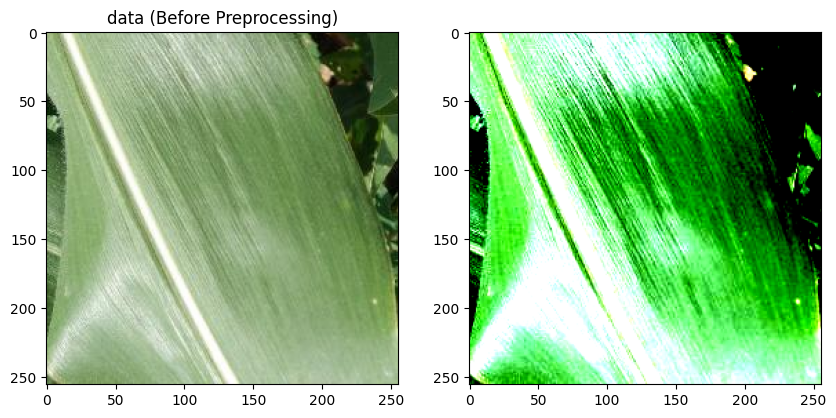

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [ ]:
single_prediction = model.forward((test[-1][0]).to(device).unsqueeze(0))
single_prediction

tensor([[-5.3005, -2.9518, -2.9220,  6.4261]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
single_prediction = int(torch.max(single_prediction, 1)[1])
print("Predicted Class:", labels_for_viz[single_prediction])

KeyError: 3

## Save Model

In [ ]:
torch.save(model.state_dict(), "model.pth")